In [7]:
import os
import madmom
import libfmp
import glob
import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import soundfile as sf
import librosa
from madmom.features.downbeats import RNNDownBeatProcessor as mmrnn
import numpy as np


folder_dir = './'
wav_prefix = 'Bach_Fugue_bwv_848_LeeSH01M_30'

init_tracks = {
    'int16-48000hz': os.path.join(folder_dir, 'audio', 'Bach_Fugue_bwv_848_LeeSH01M_30_AdAd_48000_int16.wav'),
    'float32-44100hz': os.path.join(folder_dir, 'audio', 'Bach_Fugue_bwv_848_LeeSH01M_30_AdAd_44100_float32.wav'), 
    'float32-48000hz': os.path.join(folder_dir, 'audio', 'Bach_Fugue_bwv_848_LeeSH01M_30_AdAd_48000_float32.wav'), 
    'int16-44100hz':  os.path.join(folder_dir, 'audio', 'Bach_Fugue_bwv_848_LeeSH01M_30_AdAd_44100_int16.wav'), 
    }

##################################################
# Load the recordings and check their formats
##################################################
for a_format, wavpath in init_tracks.items():
    print(os.path.basename(wavpath))
    # print(wavpath)
    audio_mm, rate_mm = madmom.io.load_audio_file(wavpath, num_channels = 1, dtype = None)
    print('--> dtype:{}, rate:{}hz'.format(audio_mm.dtype, rate_mm))

Bach_Fugue_bwv_848_LeeSH01M_30_AdAd_48000_int16.wav
--> dtype:int16, rate:48000hz
Bach_Fugue_bwv_848_LeeSH01M_30_AdAd_44100_float32.wav
--> dtype:float32, rate:44100hz
Bach_Fugue_bwv_848_LeeSH01M_30_AdAd_48000_float32.wav
--> dtype:float32, rate:48000hz
Bach_Fugue_bwv_848_LeeSH01M_30_AdAd_44100_int16.wav
--> dtype:int16, rate:44100hz


In [8]:
##########################################################################
# Set input orders and generate activations without re-initialization
##########################################################################

input_type_order = [
    ('float32-44100hz', 'float32-44100hz'), 
    ('float32-44100hz', 'float32-48000hz'), 
    ('float32-44100hz', 'int16-44100hz'),
    ('int16-44100hz', 'float32-44100hz'), 
    ]

result_dict = {}

for init_type, test_type in input_type_order:

    # acti_init = model(test_track )
    # acti_test = model(test_track )
    model = mmrnn()
    acti_init = model(init_tracks[init_type])
    acti_test = model(init_tracks[test_type])
    # result_dict[inputformat] = (acti_test)
    input_format = 'First input: {}, second input: {}'.format(init_type, test_type)
    result_dict[input_format] = (acti_test, acti_init)

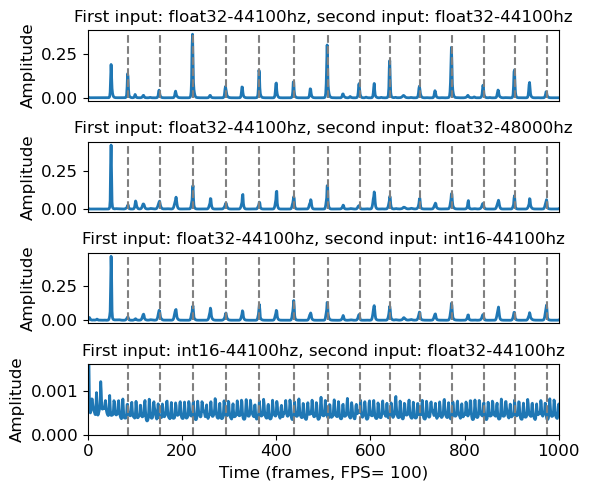

In [9]:
######################################
# plot to see differences 
######################################
annpath = os.path.join(folder_dir, 'annotations', 'Bach_Fugue_bwv_848_LeeSH01M.beats')
beat_ann = np.loadtxt(annpath)
### plot to see differences--> 
plot_ind = 1 ### 0 for downbeat, 1 for beat
fontsize = 12
linewidth = 2

fig, axs = plt.subplots(len(result_dict), 1, figsize = (6, 5))
for ind, (inputformat, (test_acti, init_acti)) in enumerate(result_dict.items()):
    # if ind==2:
    #     break
    # axs[ind].plot(init_acti[:, plot_ind], linewidth = linewidth)
    axs[ind].plot(test_acti[:, plot_ind], linewidth = linewidth)
    # title = 'Init input format: {}'.format(inputformat)
    # title = 'Test Track Format: {}'.format(inputformat)
    title = inputformat
    axs[ind].set_title(title, fontsize = fontsize)
    
    axs[ind].set_ylabel('Amplitude', fontsize = fontsize)
    axs[ind].vlines(beat_ann[:, 0]*100, 0, test_acti[:, plot_ind].max()+0.002, 
                    label = 'beat annotations', linestyle = 'dashed', 
                    color = 'gray')
    axs[ind].set_xlim([0, 1000])
    
    # axs[ind].set_ylim([0, test_acti[:, plot_ind].mean()+ np.median(test_acti[:, plot_ind])])
    if ind ==3:
        axs[ind].set_ylim([0, 0.0016])
    else:
        axs[ind].set_xticks([])
    # if ind ==1:
    # axs[ind].set_ylim([0, 0.0016])
    
    axs[ind].tick_params(axis='both', which='major', labelsize=fontsize)
axs[ind].set_xlabel('Time (frames, FPS= 100)', fontsize = fontsize)
# axs[ind].set_xlabel('Time (frames, FPS= 100)', fontsize = fontsize)
fig.tight_layout()